<a href="https://colab.research.google.com/github/shantanu-jain-35/coms-4995-medical-imaging/blob/master/coms_4995_project_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing the openslide libraries

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python
!pip install ipython-autotime
%load_ext autotime

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (187 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
import shutil
import random
from PIL import Image
from skimage.color import rgb2gray

time: 285 ms (started: 2021-04-25 13:41:52 +00:00)


In [ ]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/
time: 15.7 s (started: 2021-04-25 13:42:05 +00:00)


### Storing the data in a lists

In [ ]:
# dataset path
dataset_path = "/content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset"
PATCH_SIZE = 100
LEVEL = 5

time: 1.83 ms (started: 2021-04-25 15:40:40 +00:00)


In [ ]:
# tumor path and mask path
tumor_path = os.path.join(dataset_path, 'tumor')
mask_path = os.path.join(dataset_path, 'tumor_mask')
test_tumor_path = os.path.join(dataset_path, 'test', 'tumor')
test_tumor_mask_path = os.path.join(dataset_path, 'test', 'tumor_mask')

time: 2.67 ms (started: 2021-04-25 15:40:43 +00:00)


In [ ]:
# adding the files in lists for maintaining consistency
tumors_tifs = []
tumors_mask_tifs = []
test_tumors_tifs = []
test_tumors_mask_tifs = []
for filename in os.listdir(tumor_path):
    tumors_tifs.append(os.path.join(tumor_path, filename))
for filename in os.listdir(mask_path):
    tumors_mask_tifs.append(os.path.join(mask_path, filename))
for filename in os.listdir(test_tumor_path):
    test_tumors_tifs.append(os.path.join(test_tumor_path, filename))    
for filename in os.listdir(test_tumor_mask_path):
    test_tumors_mask_tifs.append(os.path.join(test_tumor_mask_path, filename))    

tumors_tifs.sort()
tumors_mask_tifs.sort()
test_tumors_tifs.sort()
test_tumors_mask_tifs.sort()
print("Length of tumor tiffs: {}".format(len(tumors_tifs)))
print("Length of tumor mask tiffs: {}".format(len(tumors_mask_tifs)))
print("Length of test tumor tiffs: {}".format(len(test_tumors_tifs)))
print("Length of test tumor mask tiffs: {}".format(len(test_tumors_mask_tifs)))

Length of tumor tiffs: 19
Length of tumor mask tiffs: 19
Length of test tumor tiffs: 2
Length of test tumor mask tiffs: 2
time: 24.8 ms (started: 2021-04-25 16:54:17 +00:00)


In [ ]:
# # split the dataset into training and test 
# # having 2 tiff files in the test set

# indices = random.sample(range(len(tumors_tifs)), k=2)
# test_tumor_tifs = []
# test_tumor_mask_tifs = []
# for index in indices:
#     test_tumor_tifs.append(tumors_tifs[index])
#     test_tumor_mask_tifs.append(tumors_mask_tifs[index])
#     tumors_tifs.pop(index)
#     tumors_mask_tifs.pop(index)

# # write these files in the camelyon directory in the test folder


In [ ]:
# read slide and return an image
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

time: 5.83 ms (started: 2021-04-25 15:40:56 +00:00)


### Removing the gray regions 

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

# tissue_pixels = find_tissue_pixels(slide_image)
# percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
# print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

time: 13.3 ms (started: 2021-04-25 15:41:00 +00:00)


In [ ]:
def find_tissue_percentage(slide_patches):
    tissue_percentage = []
    for slide in slide_patches:
        tissue_pixels = find_tissue_pixels(slide)
        percent_tissue = len(tissue_pixels) / float(slide.shape[0] * slide.shape[0]) * 100
        print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue))
        tissue_percentage.append(percent_tissue)

    return tissue_percentage

time: 5.43 ms (started: 2021-04-25 15:41:01 +00:00)


In [ ]:
def check_tissue_percentage_threshold(slide_image, threshold_percentage=12):
    tissue_pixels = find_tissue_pixels(slide_image)
    percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
    if percent_tissue < threshold_percentage:
        return False
    return True

time: 4.14 ms (started: 2021-04-25 15:41:04 +00:00)


### Get patches from the tiff files

In [ ]:
def get_patches(tumors, masks, patch_size=100, level=5, test_data=False, threshold_percentage=12):
    slides_patches = []
    cancerous_patches = []
    for tumor, mask in zip(tumors, masks):
        # get wsi for the tiffs
        tumor_image = open_slide(tumor)
        mask_image = open_slide(mask)

        # strides for the patch
        stride_width = tumor_image.level_dimensions[level][0] // patch_size
        stride_height = tumor_image.level_dimensions[level][1] // patch_size

        # downsampling factor
        downsample_factor = tumor_image.level_downsamples[level]

        print("For tumor: {}".format(tumor))
        print("width, height, downsample: {}, {}, {}".format(stride_width, stride_height, downsample_factor))

        for width in range(stride_width):
            for height in range(stride_height):
                top_x = int(patch_size * width * downsample_factor)
                top_y = int(patch_size * height * downsample_factor)

                # slide patch
                slide_patch = read_slide(tumor_image, top_x, top_y, level, width=patch_size, height=patch_size)
                # mask patch
                mask_patch = read_slide(mask_image, top_x, top_y, level, width=patch_size, height=patch_size)

                if test_data == False and check_tissue_percentage_threshold(slide_patch, threshold_percentage) == False:
                    continue

                slides_patches.append(slide_patch)

                if np.sum(mask_patch[:, :, 0] > 0):
                    cancerous_patches.append(1)
                else:
                    cancerous_patches.append(0)
    return slides_patches, cancerous_patches


time: 32.5 ms (started: 2021-04-25 16:17:06 +00:00)


In [ ]:
slides, cancerous = get_patches(tumors_tifs, tumors_mask_tifs, level=LEVEL, patch_size=PATCH_SIZE, threshold_percentage=11)

For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_001.tiff
width, height, downsample: 30, 69, 32.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_002.tif
width, height, downsample: 30, 68, 32.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_005.tif
width, height, downsample: 30, 68, 32.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_012.tif
width, height, downsample: 30, 67, 32.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_016.tif
width, height, downsample: 30, 69, 32.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_019.tif
width, height, downsample: 30, 68, 32.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_031.tif
width, height, downsample: 30, 69, 32.0
For tumor: /content/drive/MyDrive/Columbia_Assignments

In [ ]:
print("Number of slides: {}".format(len(slides)))
print("Number of cancerous: {}".format(np.sum(cancerous)))
# plt.imshow(slides[1600])

Number of slides: 4784
Number of cancerous: 632
time: 5.87 ms (started: 2021-04-25 16:57:21 +00:00)


5112 tissue_pixels pixels (51.1 percent of the image)
1999 tissue_pixels pixels (20.0 percent of the image)
2666 tissue_pixels pixels (26.7 percent of the image)
6151 tissue_pixels pixels (61.5 percent of the image)
7792 tissue_pixels pixels (77.9 percent of the image)
4329 tissue_pixels pixels (43.3 percent of the image)
1313 tissue_pixels pixels (13.1 percent of the image)
1238 tissue_pixels pixels (12.4 percent of the image)
1532 tissue_pixels pixels (15.3 percent of the image)
2164 tissue_pixels pixels (21.6 percent of the image)
5021 tissue_pixels pixels (50.2 percent of the image)
2322 tissue_pixels pixels (23.2 percent of the image)
2183 tissue_pixels pixels (21.8 percent of the image)
6782 tissue_pixels pixels (67.8 percent of the image)
9918 tissue_pixels pixels (99.2 percent of the image)
9953 tissue_pixels pixels (99.5 percent of the image)
5358 tissue_pixels pixels (53.6 percent of the image)
1967 tissue_pixels pixels (19.7 percent of the image)
4997 tissue_pixels pixels (5

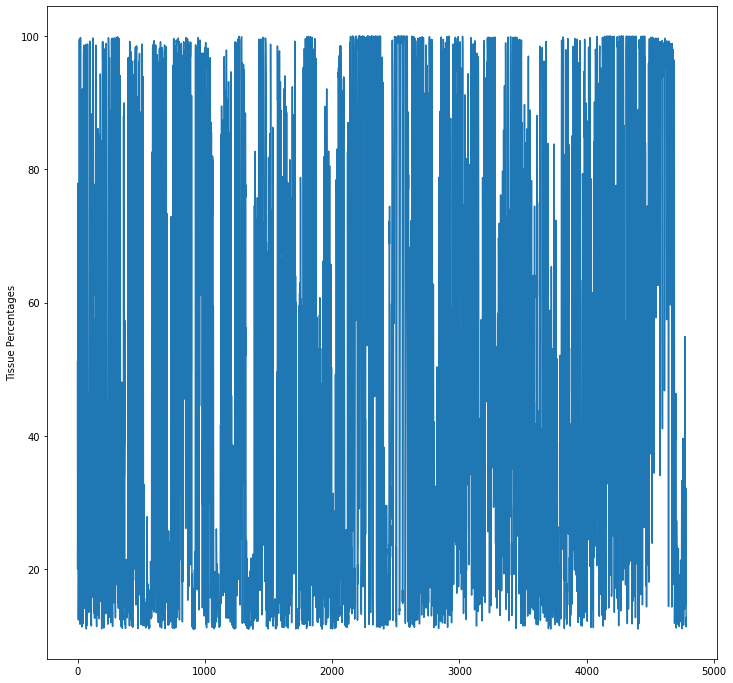

time: 14.9 s (started: 2021-04-25 16:57:24 +00:00)


In [ ]:
tissue_percentage = find_tissue_percentage(slides)
print("Average tissue percentage: {}".format(np.mean(tissue_percentage)))

# plot the percentage graph
plt.figure(figsize=(12,12))
plt.plot(tissue_percentage)
plt.ylabel("Tissue Percentages")
plt.show()

### Class names in an array

In [ ]:
class_names = ['normal', 'cancerous']

time: 1.12 ms (started: 2021-04-25 16:57:48 +00:00)


### Visualizing the dataset

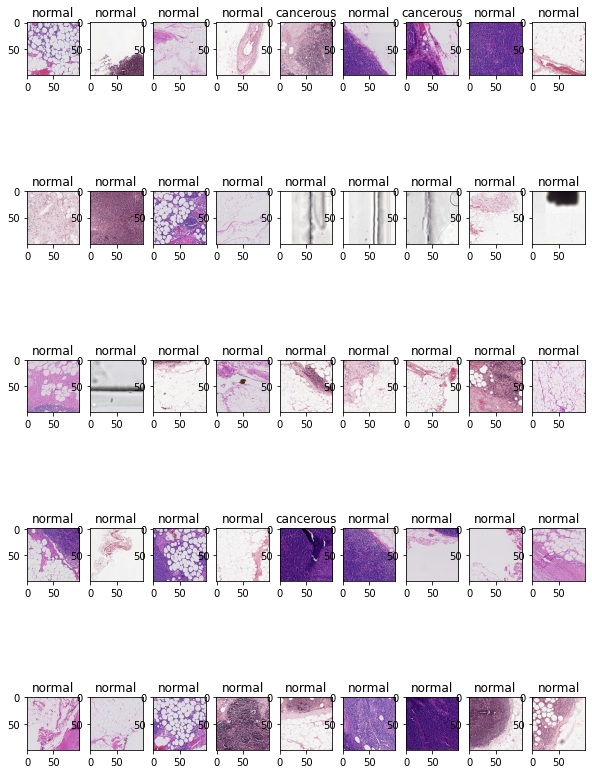

time: 5.8 s (started: 2021-04-25 17:07:50 +00:00)


In [ ]:
plt.figure(figsize=(10, 15))
# i = 0
# for images, labels in train_ds.take(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[0].numpy().astype("uint8"))
#     plt.title(class_names[labels[0]])
#     plt.axis("off")
#     i += 1

for i in range(45):
    ax = plt.subplot(5, 9, i + 1)
    index = random.randint(0, len(slides))
    plt.imshow(slides[index])
    plt.title(class_names[cancerous[index]])

### Creating dataset with normal and cancerous images

In [ ]:
# creating two directories for normal and cancerous
!mkdir -p /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/camelyon16/normal
!mkdir -p /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/camelyon16/cancerous

time: 243 ms (started: 2021-04-23 13:24:22 +00:00)


In [ ]:
# function to convert patch into jpegs
normal_path = "/content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/camelyon16/normal"
image = Image.fromarray(slides[0])
image.save(os.path.join(normal_path, 'normal_001.jpeg'))


time: 565 ms (started: 2021-04-23 13:30:35 +00:00)


In [ ]:
def create_dataset(slides, cancerous):
    normal_folder_path = "/content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/camelyon16/normal"
    cancerous_folder_path = "/content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/camelyon16/cancerous"

    # deleting the folders so as to avoid overlap
    shutil.rmtree(normal_folder_path)
    shutil.rmtree(cancerous_folder_path)

    # creating the deleted folders
    os.makedirs(normal_folder_path)
    os.makedirs(cancerous_folder_path)

    normal_slide_count = 0
    cancerous_slide_count = 0

    for index in range(len(slides)):
        image = Image.fromarray(slides[index])
        if cancerous[index] == 1:
            cancerous_slide_count += 1
            image.save(os.path.join(cancerous_folder_path, 'cancerous_'+str(cancerous_slide_count)+'.jpeg'))
        else:
            normal_slide_count += 1
            image.save(os.path.join(normal_folder_path, 'normal_'+str(normal_slide_count)+'.jpeg'))

time: 15.5 ms (started: 2021-04-25 04:18:30 +00:00)


In [ ]:
create_dataset(slides, cancerous)

time: 33.6 s (started: 2021-04-25 04:18:56 +00:00)


### Creating the test dataset

In [ ]:
test_patches, test_cancerous_patches = get_patches(
    test_tumors_tifs,
    test_tumors_mask_tifs, 
    patch_size=PATCH_SIZE, 
    level=LEVEL, 
    test_data=True
    )

For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/test/tumor/tumor_023.tif
width, height, downsample: 30, 69, 32.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/test/tumor/tumor_075.tif
width, height, downsample: 28, 24, 32.0
time: 12.2 s (started: 2021-04-25 16:26:58 +00:00)


In [ ]:
print("Number of slides: {}".format(len(test_patches)))
print("Number of cancerous: {}".format(np.sum(test_cancerous_patches)))
# plt.imshow(slides[1600])

NameError: ignored

time: 42.9 ms (started: 2021-04-25 16:26:56 +00:00)
